# Phase II: Testing ROS with Several Models for Comparison


## I repeat the steps I took to prepare the dataset from my EDA

In [1]:
'''
*    Text Pre-Processing    *
'''
import pandas as pd
import nltk
import re
import numpy as np
import umap.umap_ as umap
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


'''
*    Plotting    *
'''
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import umap.plot
from yellowbrick.text import FreqDistVisualizer
from wordcloud import WordCloud, ImageColorGenerator


'''
*    Training & Metrics    *
'''
import logging
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
from scipy import interp
from itertools import cycle



'''
*    Model Selection    *
'''
import pickle
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

In [21]:
'''import'''
df = pd.read_csv('master_f.csv')
df.fillna(method = 'pad')


'''assigning labels and storing in variable to prepare for holdout creation'''
df_dep = df.loc[df['label'] == 0] 
df_ptsd = df.loc[df['label'] == 1]
df_cptsd = df.loc[df['label'] == 2] 
df_bpd = df.loc[df['label'] == 3]
df_bipolar = df.loc[df['label'] == 4] 
df_diss = df.loc[df['label'] == 5]


'''creating holdouts'''
df_dep_holdout = df_dep.iloc[:100]
df_ptsd_holdout = df_ptsd.iloc[:100]
df_cptsd_holdout = df_cptsd.iloc[:100]
df_bpd_holdout = df_bpd.iloc[:100]
df_bipolar_holdout = df_bipolar.iloc[:100]
df_diss_holdout = df_diss.iloc[:100]


'''re-defining variables with holdout documents ommitted'''
df_dep = df_dep.iloc[100:]
df_ptsd = df_ptsd.iloc[100:]
df_cptsd = df_cptsd.iloc[100:]
df_bpd = df_bpd.iloc[100:]
df_bipolar = df_bipolar.iloc[100:]
df_diss = df_diss.iloc[100:]


'''concat the pieces back together'''
df = pd.concat([df_dep, df_ptsd, df_cptsd, df_bpd, df_bipolar, df_diss])
df_holdout = pd.concat([df_dep_holdout, df_ptsd_holdout, df_cptsd_holdout, df_bpd_holdout, df_bipolar_holdout, df_diss_holdout])
df.dropna()

print(df.shape)
print(df.keys())

(8921, 2)
Index(['label', 'text'], dtype='object')


In [22]:
'''
# defining symbols/characters to remove
# set the stopword to 'english'
# define tokenizer & lemmatizer
'''
REPLACE_BY_SPACE_RE = re.compile("[/(){}\[\]\|@,;']")
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
TOKENIZER = RegexpTokenizer(r'\w+')
LEMMATIZER = WordNetLemmatizer()




'''defining method for cleaning text input'''
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text)
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(x for x in text.split() if x not in STOPWORDS) # delete stopwors from text
    return text


'''defining lemmatizer'''
def word_lemmatizer(text):
    lem_text = [LEMMATIZER.lemmatize(x) for x in text]
    return lem_text  


'''applying pre-processing'''
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].apply(lambda x: TOKENIZER.tokenize(x))
df['text'] = df['text'].apply(lambda x: word_lemmatizer(x))


df = df.dropna(how='any',axis=0)
df.shape

(8921, 2)

In [23]:
'''defining vectorizer'''
docs = df['text'].astype(str).dropna()
vectorizer = TfidfVectorizer(stop_words='english', 
                             min_df = 5,
                             ngram_range = (1,2),
                             use_idf = True,
                             max_df = 0.5, 
                             smooth_idf=True)


'''vectorizing text, and mapping the labels'''
label_map = {0: 'Depression',
             1: 'PTSD',
             2: 'CPTSD',
             3: 'Borderline',
             4: 'Bipolar',
             5: 'Dissociation'}

X = vectorizer.fit_transform(docs).toarray()
y = df['label'].values
y_label = df['label'].map(label_map)


print(X.shape)
y.shape

(8921, 21045)


(8921,)

In [24]:
'''Random Over Sampling is a method that evens out the distribution of your classes by inflating the underrepresented classes.'''
ovs = RandomOverSampler(random_state=42)
X_res, y_res = ovs.fit_resample(X,y)


'''Random Under Sampling is the converse of ROS, where the overrepresented classes are reduced to match the underrepresented classes'''
ous = RandomUnderSampler(random_state=42)
X_res_b, y_res_b = ous.fit_resample(X,y)

# Random Over Sampling - put to the test

I specified several neighborhoods to compare performance. I raised the dimensionality to 6 because the number of unique classes I am examining is 6. Hopefully I retain more information this way and achieve better separation in the classes.

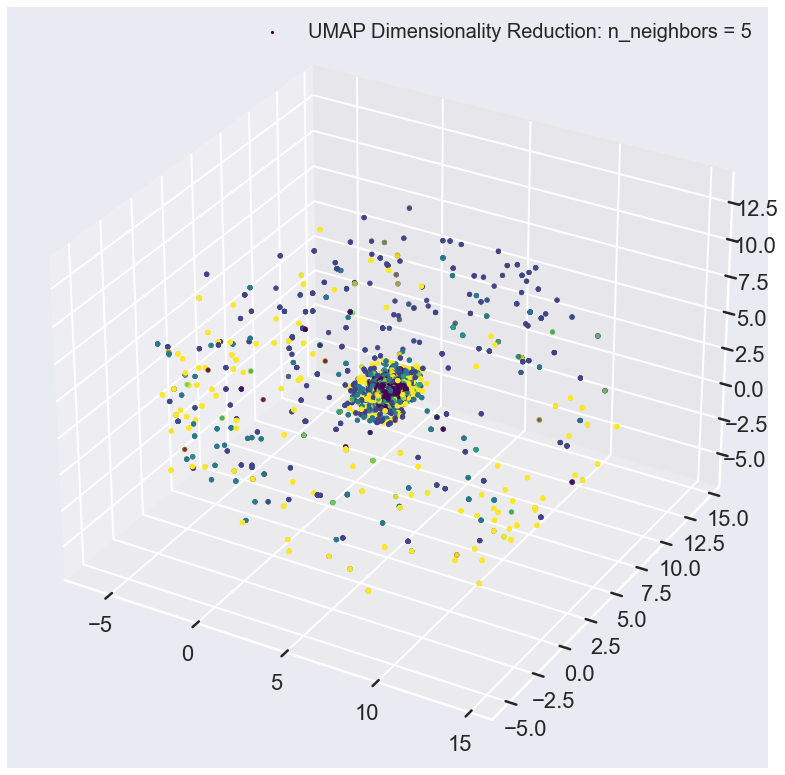

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                    model_name accuracy_score precision_score recall_score  \
2                Random Forest       0.677905        0.680734     0.679594   
6           K Nearest Neighbor       0.597957        0.598051     0.598926   
3               Decsision Tree        0.58212        0.578416     0.583946   
4                     AdaBoost        0.36143        0.356671     0.362307   
7          Logistic Regression       0.309579        0.313932     0.309906   
5         Gaussian Naive Bayes       0.286335        0.331686     0.283748   
1  Stochastic Gradient Descent       0.171903        0.186148     0.175355   
0                        Dummy       0.162963         0.02716     0.166667   

   f1_score  
2  0.678407  
6  0.596022  
3  0.580889  
4  0.353029  
7  0.308412  
5  0.235562  
1  0.087426  
0  0.046709  


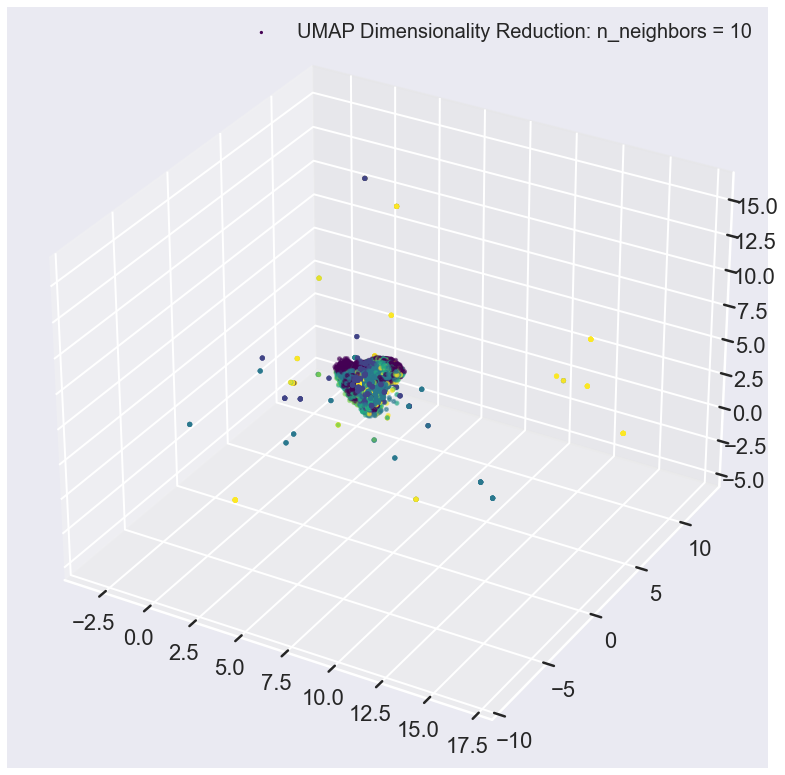

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                    model_name accuracy_score precision_score recall_score  \
2                Random Forest       0.830396        0.830593     0.831199   
6           K Nearest Neighbor       0.822478        0.823261     0.823246   
3               Decsision Tree       0.719796         0.72071     0.720697   
4                     AdaBoost       0.502682        0.498827      0.50424   
7          Logistic Regression       0.408174         0.38247     0.410872   
1  Stochastic Gradient Descent       0.263857        0.409633     0.266081   
5         Gaussian Naive Bayes       0.230396        0.233371     0.230779   
0                        Dummy       0.162963         0.02716     0.166667   

   f1_score  
2   0.83065  
6  0.822843  
3  0.720525  
4  0.490089  
7  0.372187  
1  0.192554  
5   0.16683  
0  0.046709  


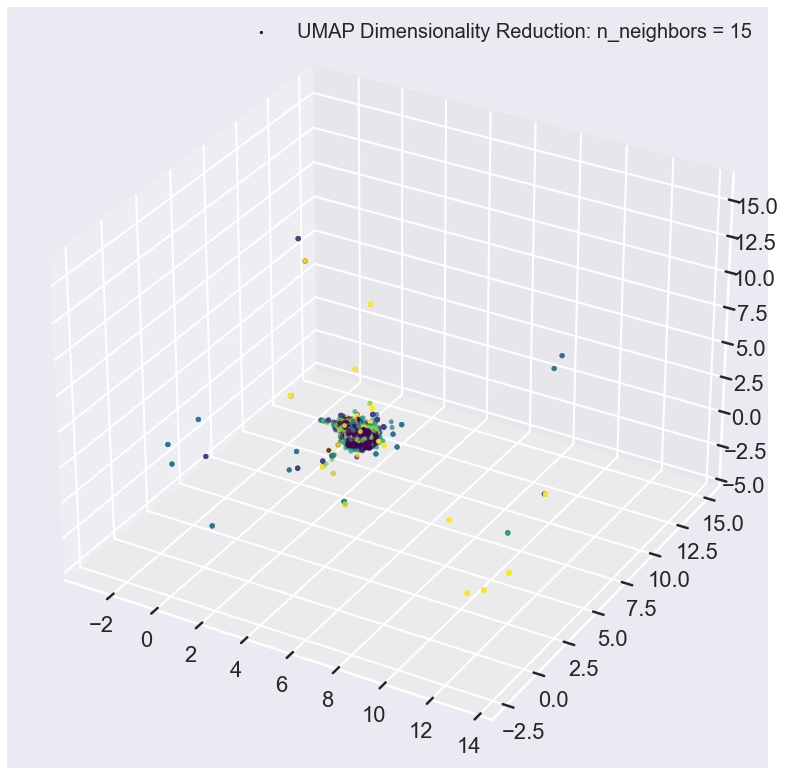

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.834738        0.835094     0.834918   
2                Random Forest       0.831673        0.832711     0.831988   
3               Decsision Tree       0.723627         0.72354     0.723709   
4                     AdaBoost       0.448276        0.437145     0.450582   
7          Logistic Regression       0.321328        0.297903     0.322801   
5         Gaussian Naive Bayes       0.284036        0.303508      0.28293   
1  Stochastic Gradient Descent       0.265134        0.321222      0.26534   
0                        Dummy       0.162963         0.02716     0.166667   

   f1_score  
6   0.83448  
2   0.83148  
3  0.723462  
4  0.428203  
7  0.283066  
5  0.216652  
1  0.161947  
0  0.046709  


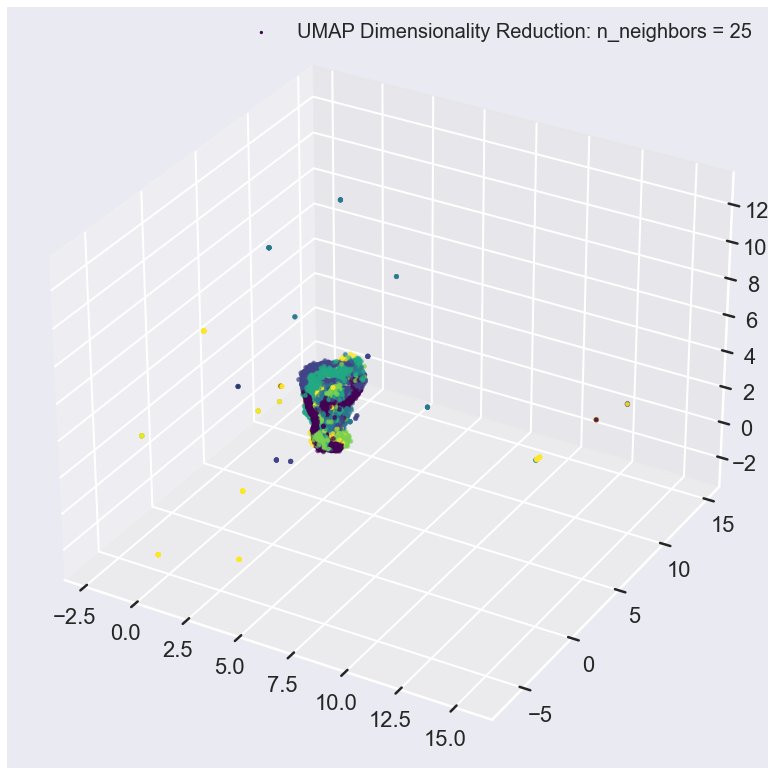

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.930524        0.930432     0.930436   
2                Random Forest       0.925415        0.925394     0.925424   
3               Decsision Tree       0.864623        0.865022     0.864414   
4                     AdaBoost       0.480715        0.478305     0.481978   
7          Logistic Regression       0.366028        0.333289     0.367914   
5         Gaussian Naive Bayes       0.326181        0.409961     0.328137   
1  Stochastic Gradient Descent       0.168327        0.149156      0.17205   
0                        Dummy       0.162963         0.02716     0.166667   

   f1_score  
6  0.930403  
2  0.925326  
3  0.864522  
4   0.47658  
7  0.310359  
5  0.267151  
1  0.058185  
0  0.046709  


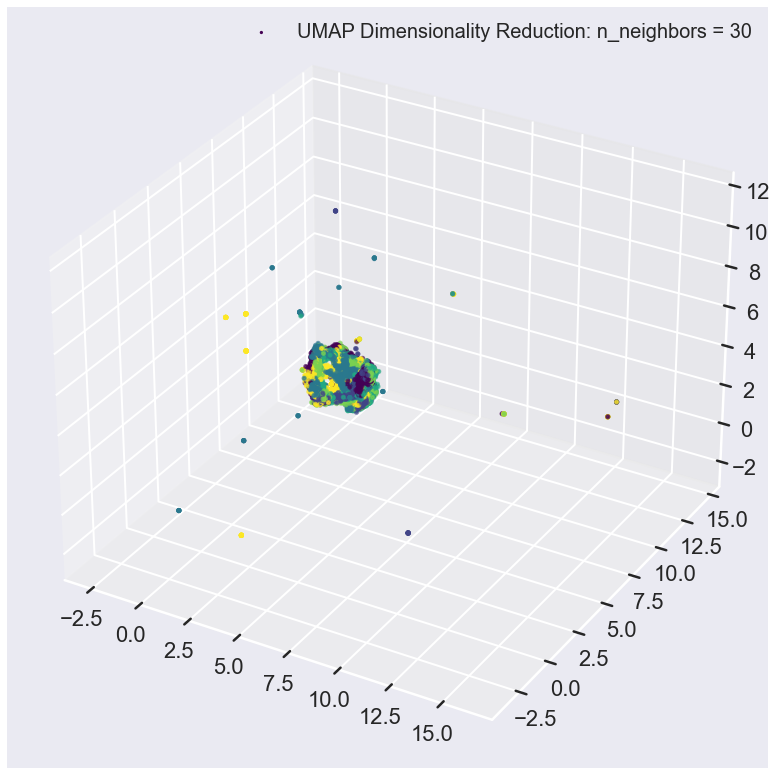

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.882503        0.882726      0.88279   
2                Random Forest       0.871775        0.871493     0.872104   
3               Decsision Tree       0.778033        0.779045     0.778609   
4                     AdaBoost       0.440613        0.442104     0.441804   
7          Logistic Regression       0.331801        0.297766     0.334111   
5         Gaussian Naive Bayes       0.317497        0.266995     0.319563   
1  Stochastic Gradient Descent       0.220945        0.154489     0.220678   
0                        Dummy       0.162963         0.02716     0.166667   

   f1_score  
6  0.882454  
2  0.871624  
3  0.778519  
4  0.427486  
7  0.287764  
5  0.249114  
1  0.134343  
0  0.046709  


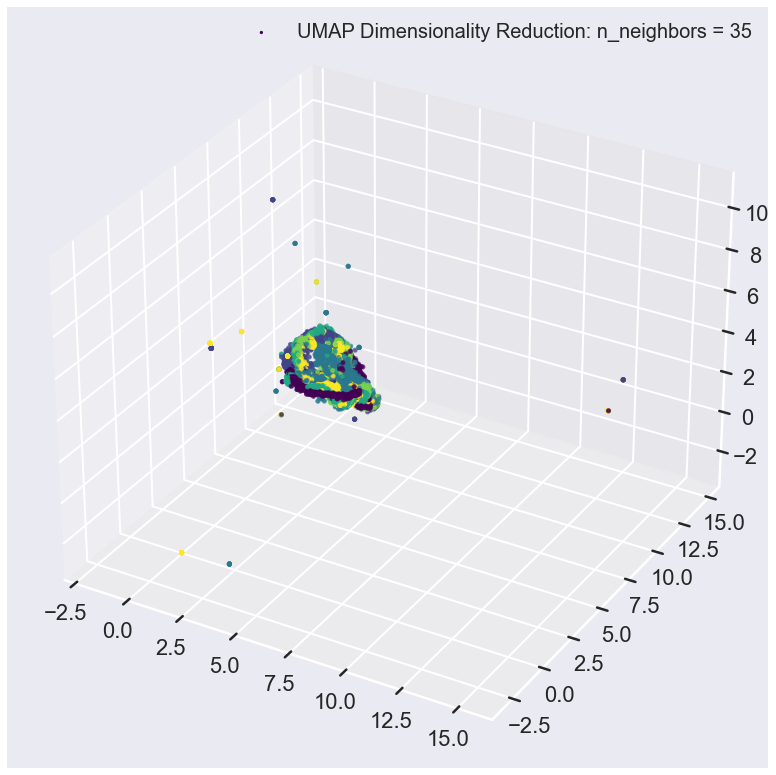

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.897318         0.89718     0.897398   
2                Random Forest       0.891188         0.89073     0.891269   
3               Decsision Tree       0.818391        0.818865     0.818411   
4                     AdaBoost       0.452874         0.44099     0.454849   
7          Logistic Regression       0.332312        0.293007     0.334498   
5         Gaussian Naive Bayes       0.310089        0.329801     0.311648   
1  Stochastic Gradient Descent       0.217625        0.219282     0.217802   
0                        Dummy       0.162963         0.02716     0.166667   

   f1_score  
6  0.897225  
2  0.890833  
3   0.81861  
4  0.435123  
7  0.282712  
5  0.239573  
1  0.144725  
0  0.046709  


In [25]:
neighbors = [5,10,15,25,30,35]

def umap_plot(neighbors):
    for i in neighbors:
        fit = umap.UMAP(n_neighbors = i,
                        min_dist = .1,
                        n_components = 6,
                        metric = 'euclidean')
        data_umap = fit.fit_transform(X_res)

    
        sns.set(style='darkgrid', context='poster', rc={'figure.figsize':(20,14)})
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(data_umap[:,0], data_umap[:,1], data_umap[:,2], c=y_res, s=10, cmap='viridis')
        leg = plt.legend(['UMAP Dimensionality Reduction: n_neighbors = {}'.format(i)], loc='best', borderpad=0.3, 
                         shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                         markerscale=0.4)
        leg.get_frame().set_alpha(0.4)
        leg.set_draggable(state=True)
        plt.show()
        
        
        
        
        model_dict = {'Dummy' : DummyClassifier(random_state=42),
                      'Stochastic Gradient Descent' : SGDClassifier(random_state=42, loss='modified_huber'),
                      'Random Forest': RandomForestClassifier(random_state=42),
                      'Decsision Tree': DecisionTreeClassifier(random_state=42),
                      'AdaBoost': AdaBoostClassifier(random_state=42),
                      'Gaussian Naive Bayes': GaussianNB(),
                      'K Nearest Neighbor': KNeighborsClassifier(),
                      'Logistic Regression': LogisticRegression()}

#Train test split with stratified sampling for evaluation
        X_train, X_test, y_train, y_test = train_test_split(data_umap, 
                                                            y_res, 
                                                            test_size = .3, 
                                                            shuffle = True, 
                                                            random_state = 3)

#Function to get the scores for each model in a df
        def model_score_df(model_dict):   
            model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
            for k,v in model_dict.items():   
                model_name.append(k)
                v.fit(X_train, y_train)
                y_pred = v.predict(X_test)
                ac_score_list.append(accuracy_score(y_test, y_pred))
                p_score_list.append(precision_score(y_test, y_pred, average='macro'))
                r_score_list.append(recall_score(y_test, y_pred, average='macro'))
                f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
                model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
                model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
                model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
            return model_comparison_df

        print(model_score_df(model_dict))
        
        
        
umap_plot(neighbors)

## Results

I achieved the optimal result at n_neighbors = 25. I reset the data_umap variable below for further analysis.

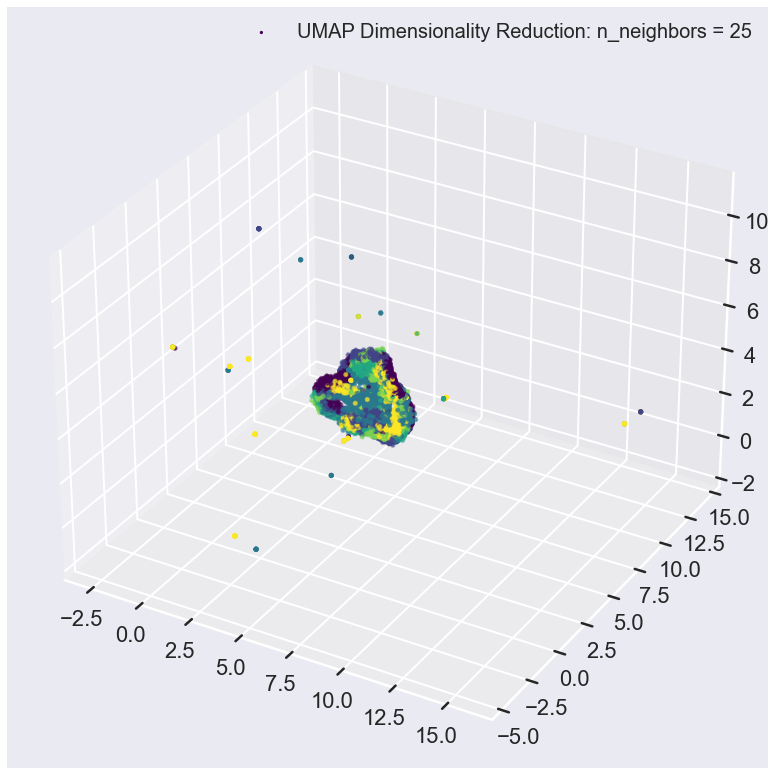

,model_name,accuracy_score,precision_score,recall_score,f1_score
3,K Nearest Neighbor,0.888123,0.888402,0.888111,0.887995
0,Random Forest,0.876884,0.876727,0.877045,0.876771
1,Decsision Tree,0.791571,0.791819,0.791945,0.79167
2,AdaBoost,0.438059,0.447938,0.439078,0.426236


In [27]:
fit = umap.UMAP(n_neighbors = 25,
                min_dist = .1,
                n_components = 6,
                metric = 'euclidean')

data_umap = fit.fit_transform(X_res)

sns.set(style='darkgrid', context='poster', rc={'figure.figsize':(20,14)})
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_umap[:,0], data_umap[:,1], data_umap[:,2], c=y_res, s=10, cmap='viridis')
leg = plt.legend(['UMAP Dimensionality Reduction: n_neighbors = 25'], loc='best', borderpad=0.3, 
                  shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'), markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.set_draggable(state=True)
plt.show()
        
model_dict = {'Random Forest': RandomForestClassifier(random_state=42),
              'Decsision Tree': DecisionTreeClassifier(random_state=42),
              'AdaBoost': AdaBoostClassifier(random_state=42),
              'K Nearest Neighbor': KNeighborsClassifier()}

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(data_umap, 
                                                    y_res, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    random_state = 3)

#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)



# KNN GridSearchCV - looking for the best parameters 

A cautionary tale, this takes a huge burden on the CPU. I used Google Colab's GPU acceleration for this portion, so please excuse the absence of an output for this cell.

In [ ]:
#KNN
n_neighbors = [5,7,10,15]
weights = ['uniform','distance']
leaf_size = [5,10,30,50]
p = [1,2]
n_jobs = [-1]

clf = KNeighborsClassifier()

params = dict(n_neighbors = n_neighbors,
              weights = weights,
              leaf_size = leaf_size,
              p = p,
              n_jobs = n_jobs)

gridsearch = GridSearchCV(clf,
                          params, 
                          cv=5,
                          verbose=1, 
                          n_jobs=-1)

knn_best_model = gridsearch.fit(X_res, y_res)

In [ ]:
KNN_best = gridsearch.best_params_
print(KNN_best)

In [28]:
knn_best_model = KNeighborsClassifier(leaf_size=5,
                                      n_jobs=-1,
                                      n_neighbors=7,
                                      p =2,
                                      weights='distance')

## Plotting the AUC/ROC Curves

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


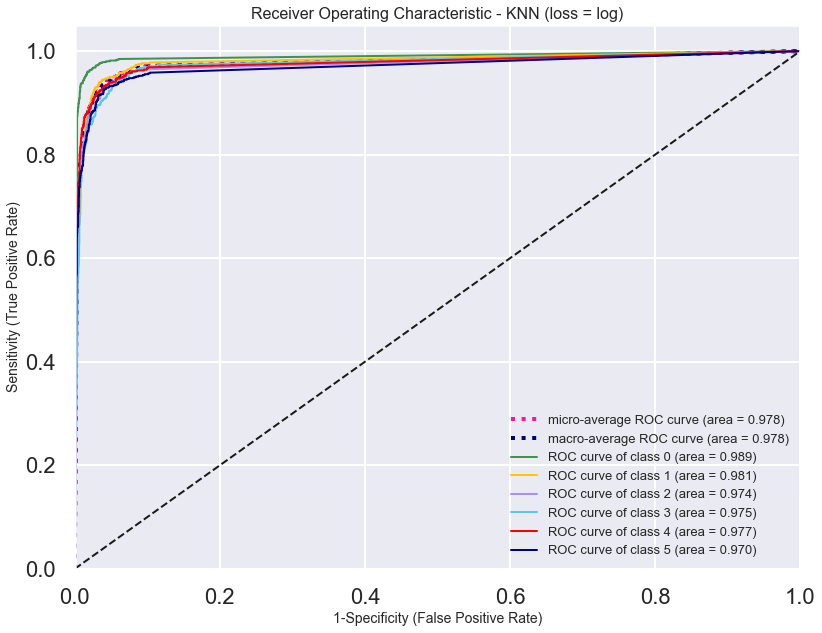

In [29]:
#Plot AUC - SGD
import numpy as np
#Binarize the labels
y_b = label_binarize(y_res, classes = [0, 1, 2, 3, 4, 5])
n_classes = y_b.shape[1]
#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(data_umap,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            random_state = 3)

#Learn to predict each class against the other
KNN_classifier = OneVsRestClassifier(knn_best_model)
y_score = KNN_classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)



#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA', 'red', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - KNN (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

## Confusion Matrix

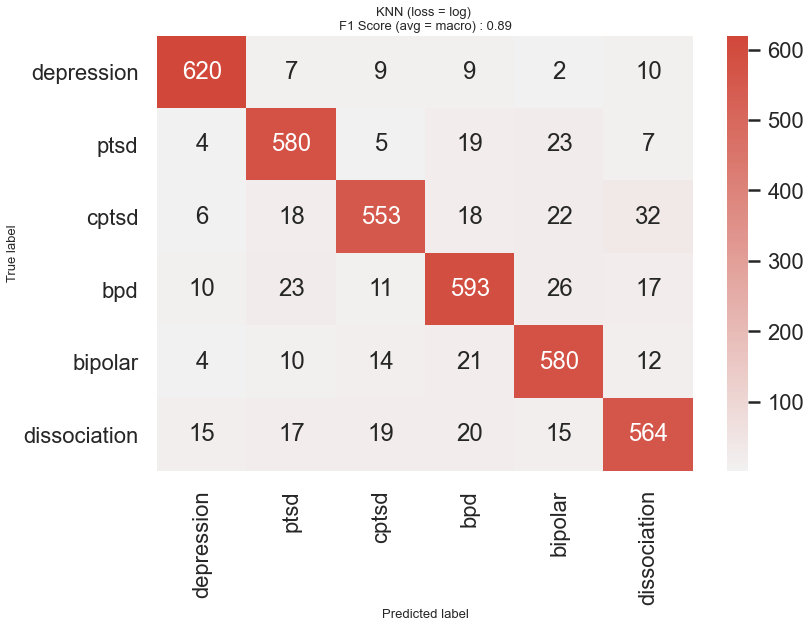

In [30]:
#Train test split with stratified sampling. Using non-binarized labels
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(data_umap, 
                                                            y_res, 
                                                            test_size = .3, 
                                                            shuffle = True, 
                                                            random_state = 3)
#Fit the training data
knn_best_model.fit(X_train_c, y_train_c)
y_pred = knn_best_model.predict(X_test_c)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test_c, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['depression','ptsd','cptsd', 'bpd', 'bipolar', 'dissociation'], 
                     columns = ['depression','ptsd','cptsd', 'bpd', 'bipolar', 'dissociation'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('KNN (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test_c, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()


## Predicting Unseen Data

In [34]:
unseen = df_holdout['text']
unseen = unseen.apply(clean_text)
unseen = unseen.apply(lambda x: TOKENIZER.tokenize(x))
unseen = unseen.apply(lambda x: word_lemmatizer(x))
unseen.dropna()
for text in unseen:
    if text == []:
        text.append('0')
unseen = unseen.astype('str')


X_unseen_tfidf = vectorizer.fit_transform(unseen).toarray() 
X_unseen = fit.fit_transform(X_unseen_tfidf)

knn_best_model.fit(data_umap,y_res)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
df_holdout['pred_knn'] = knn_best_model.predict(X_unseen)


label_num_dict = {0: 0,
                  1: 1,
                  2: 2,
                  3: 3,
                  4: 4,
                  5: 5}
labels = ['0','1','2','3','4','5']

df_holdout['correct'] = df_holdout['label'].map(label_num_dict)
df_holdout = df_holdout[['text', 'label', 'pred_knn', 'correct']]

print(accuracy_score(df_holdout['correct'], df_holdout['pred_knn']))
print(classification_report(df_holdout['correct'], df_holdout['pred_knn'], target_names = labels))
df_holdout

0.16666666666666666
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.17      1.00      0.29       100
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100
           5       0.00      0.00      0.00       100

    accuracy                           0.17       600
   macro avg       0.03      0.17      0.05       600
weighted avg       0.03      0.17      0.05       600



C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,text,label,pred_knn,correct
0,Does anyone else have intrusive thoughts and t...,0,1,0
1,My agony has started when I came off antidepre...,0,1,0
2,Two weeks I've been taking Sertraline. Mood is...,0,1,0
3,"Hi,\nI honestly don't know what is wrong with ...",0,1,0
4,"Hi, am I the only one who doesn't like my own ...",0,1,0
...,...,...,...,...
8805,I hate this feeling. \nI feel so disconnected\...,5,1,5
8806,so i mainly struggle with dissociation dpdr al...,5,1,5
8807,"I'm dissociatibg a lot, I suddenly change from...",5,1,5
8808,"Hey, everyone. I have been suffering with Depe...",5,1,5


# Random Under Sampling - put to the test
Finally, we get to review the models' performance provided a RUS.


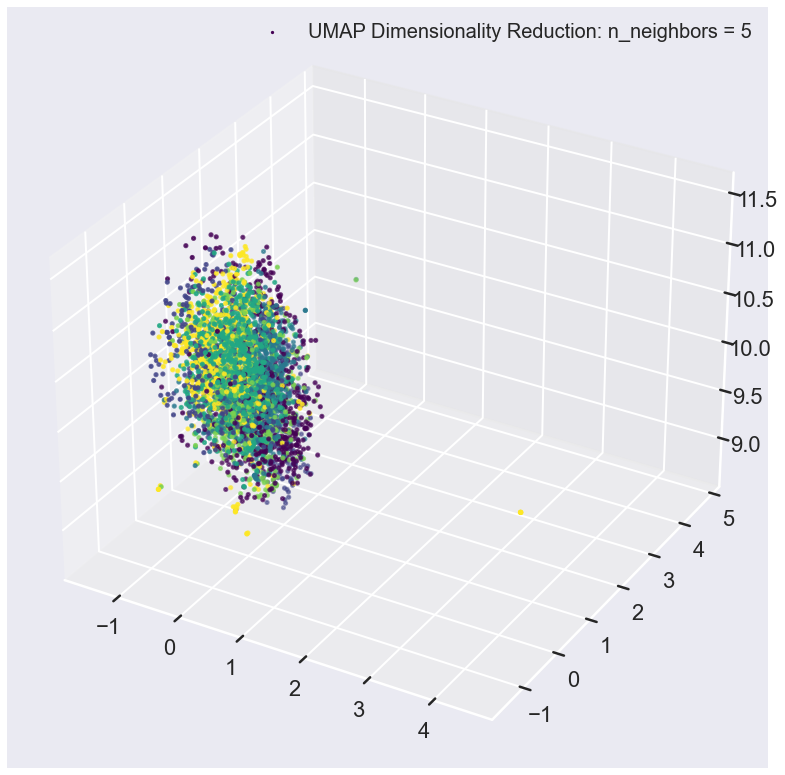

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.732723        0.729343     0.732136   
2                Random Forest       0.722731        0.719993     0.722213   
3               Decsision Tree       0.598668        0.599044      0.59799   
5         Gaussian Naive Bayes       0.567027        0.551208     0.566652   
4                     AdaBoost       0.535387        0.537364     0.534638   
7          Logistic Regression        0.50458        0.497674     0.505727   
1  Stochastic Gradient Descent       0.462115        0.522972     0.462623   
0                        Dummy       0.161532        0.026922     0.166667   

   f1_score  
6  0.730406  
2  0.720244  
3  0.597821  
5  0.552498  
4  0.532061  
7  0.494867  
1  0.408487  
0  0.046356  


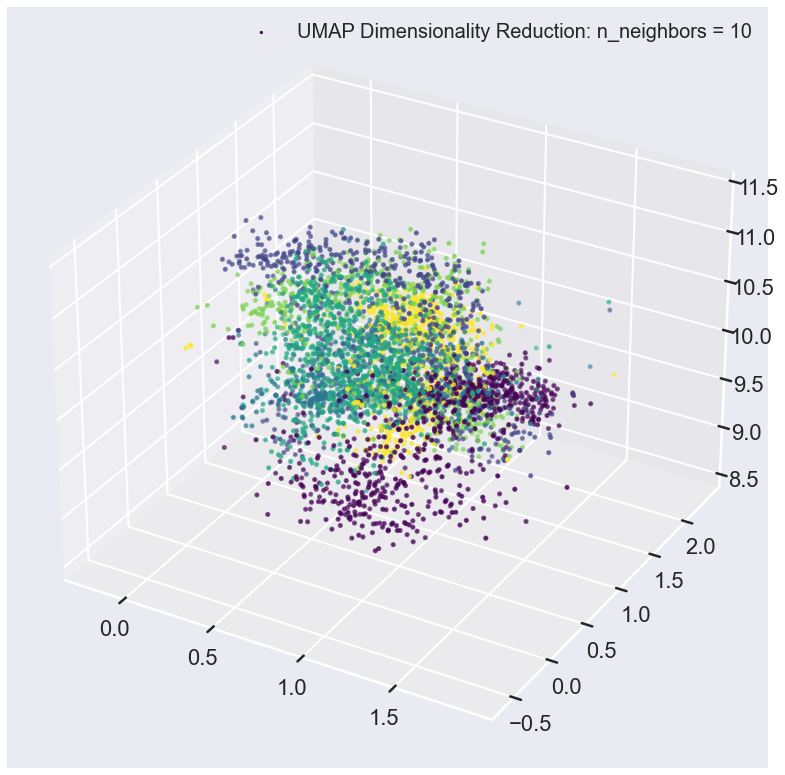

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.912573         0.91387     0.912364   
2                Random Forest       0.890924        0.893232     0.890729   
3               Decsision Tree       0.801832        0.805411     0.801164   
5         Gaussian Naive Bayes       0.646961        0.644433     0.647485   
7          Logistic Regression       0.588676        0.580488     0.587987   
4                     AdaBoost       0.577019        0.552284     0.575727   
1  Stochastic Gradient Descent        0.47627        0.488455     0.471631   
0                        Dummy       0.161532        0.026922     0.166667   

   f1_score  
6  0.912474  
2  0.891301  
3  0.802071  
5  0.628013  
7  0.573716  
4  0.554707  
1  0.413109  
0  0.046356  


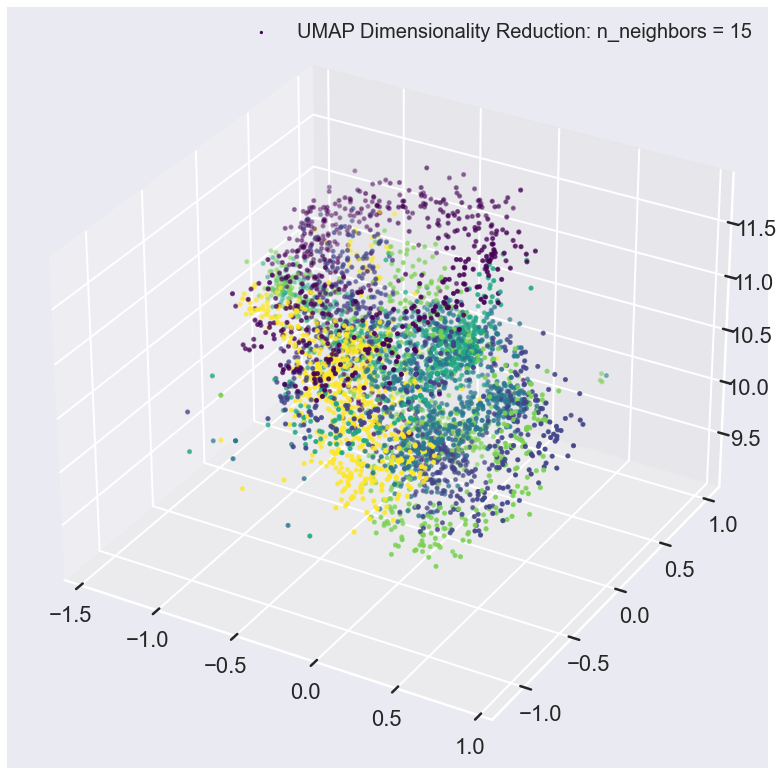

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                    model_name accuracy_score precision_score recall_score  \
2                Random Forest        0.92756        0.927361     0.927708   
6           K Nearest Neighbor       0.925895        0.926066     0.925843   
3               Decsision Tree       0.852623        0.852177     0.852387   
5         Gaussian Naive Bayes       0.592007        0.594738     0.591588   
4                     AdaBoost       0.566195        0.568201      0.56612   
7          Logistic Regression       0.484596        0.478136     0.483918   
1  Stochastic Gradient Descent       0.420483        0.512955      0.41823   
0                        Dummy       0.161532        0.026922     0.166667   

   f1_score  
2  0.927501  
6  0.925874  
3  0.852184  
5  0.579743  
4  0.550179  
7  0.476538  
1  0.365701  
0  0.046356  


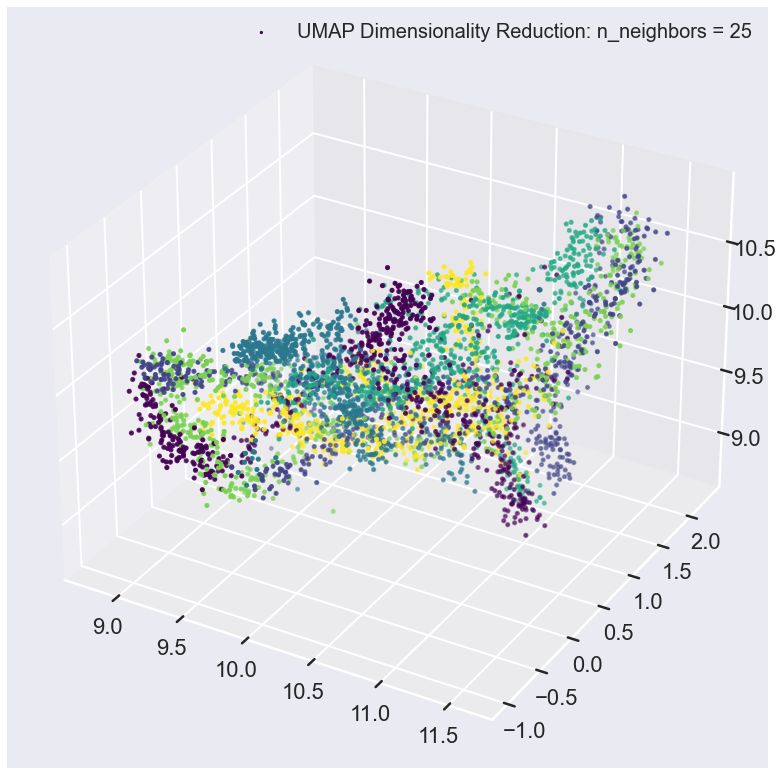

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the document

                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.922565        0.922601     0.922634   
2                Random Forest       0.918401        0.918537      0.91873   
3               Decsision Tree       0.840133        0.839782     0.840431   
5         Gaussian Naive Bayes       0.483764        0.484273     0.486123   
4                     AdaBoost       0.453789        0.451489     0.455403   
7          Logistic Regression       0.367194        0.332101     0.370652   
1  Stochastic Gradient Descent         0.2398        0.169558     0.245759   
0                        Dummy       0.161532        0.026922     0.166667   

   f1_score  
6  0.922546  
2   0.91851  
3  0.840019  
5  0.462761  
4  0.442634  
7  0.339211  
1  0.131795  
0  0.046356  


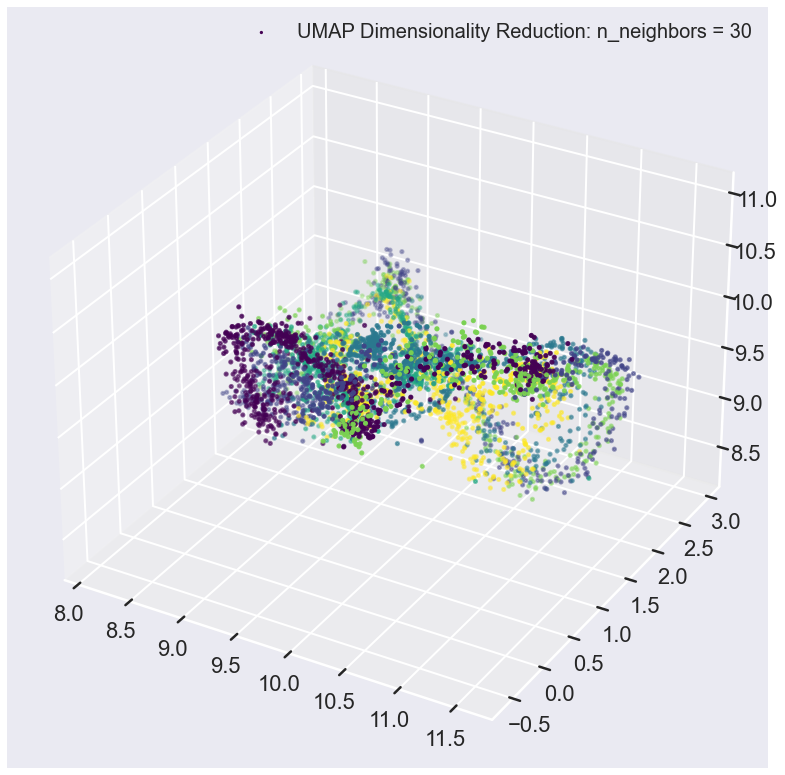

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.914238        0.913793     0.914725   
2                Random Forest       0.900916        0.900862     0.901112   
3               Decsision Tree       0.830974        0.832607     0.830775   
5         Gaussian Naive Bayes       0.475437        0.466347     0.475563   
4                     AdaBoost       0.402998         0.46719      0.40361   
7          Logistic Regression         0.4005        0.369905     0.401622   
1  Stochastic Gradient Descent       0.333888        0.335436     0.333947   
0                        Dummy       0.161532        0.026922     0.166667   

   f1_score  
6  0.913768  
2  0.900846  
3  0.831497  
5  0.454611  
4  0.405335  
7  0.377101  
1  0.280696  
0  0.046356  


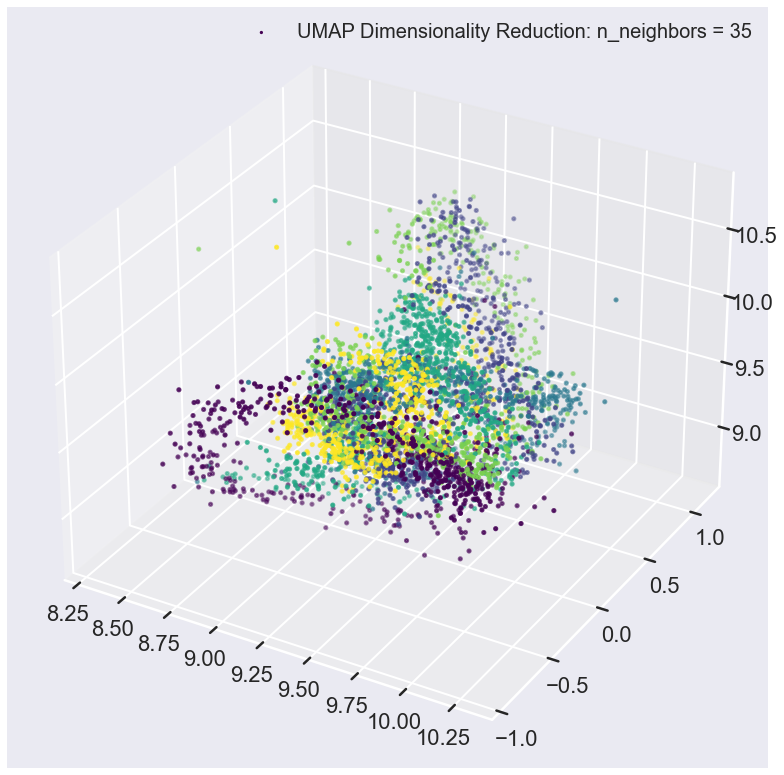

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    model_name accuracy_score precision_score recall_score  \
6           K Nearest Neighbor       0.943381        0.943759     0.943792   
2                Random Forest       0.929226        0.929341     0.929559   
3               Decsision Tree       0.866778        0.867067      0.86729   
5         Gaussian Naive Bayes       0.537885        0.548382     0.540411   
7          Logistic Regression       0.497918        0.494443      0.49784   
4                     AdaBoost       0.502914        0.505156     0.502603   
1  Stochastic Gradient Descent         0.2398        0.408457     0.234684   
0                        Dummy       0.161532        0.026922     0.166667   

   f1_score  
6  0.943539  
2  0.929363  
3  0.867063  
5  0.525685  
7  0.487164  
4  0.474609  
1   0.16099  
0  0.046356  


C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [35]:
neighbors = [5,10,15,25,30,35]

def umap_plot(neighbors):
    for i in neighbors:
        fit = umap.UMAP(n_neighbors = i,
                        min_dist = .1,
                        n_components = 6,
                        metric = 'euclidean')
        data_umap = fit.fit_transform(X_res_b)

    
        sns.set(style='darkgrid', context='poster', rc={'figure.figsize':(20,14)})
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(data_umap[:,0], data_umap[:,1], data_umap[:,2], c=y_res_b, s=10, cmap='viridis')
        leg = plt.legend(['UMAP Dimensionality Reduction: n_neighbors = {}'.format(i)], loc='best', borderpad=0.3, 
                         shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                         markerscale=0.4)
        leg.get_frame().set_alpha(0.4)
        leg.set_draggable(state=True)
        plt.show()
        
        
        
        
        model_dict = {'Dummy' : DummyClassifier(random_state=42),
                      'Stochastic Gradient Descent' : SGDClassifier(random_state=42, loss='modified_huber'),
                      'Random Forest': RandomForestClassifier(random_state=42),
                      'Decsision Tree': DecisionTreeClassifier(random_state=42),
                      'AdaBoost': AdaBoostClassifier(random_state=42),
                      'Gaussian Naive Bayes': GaussianNB(),
                      'K Nearest Neighbor': KNeighborsClassifier(),
                      'Logistic Regression': LogisticRegression()}

#Train test split with stratified sampling for evaluation
        X_train, X_test, y_train, y_test = train_test_split(data_umap, 
                                                            y_res_b, 
                                                            test_size = .3, 
                                                            shuffle = True, 
                                                            random_state = 3)

#Function to get the scores for each model in a df
        def model_score_df(model_dict):   
            model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
            for k,v in model_dict.items():   
                model_name.append(k)
                v.fit(X_train, y_train)
                y_pred = v.predict(X_test)
                ac_score_list.append(accuracy_score(y_test, y_pred))
                p_score_list.append(precision_score(y_test, y_pred, average='macro'))
                r_score_list.append(recall_score(y_test, y_pred, average='macro'))
                f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
                model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
                model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
                model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
            return model_comparison_df

        print(model_score_df(model_dict))
        
        
        
umap_plot(neighbors)

## Result - performed best at n = 35

## Same process as before

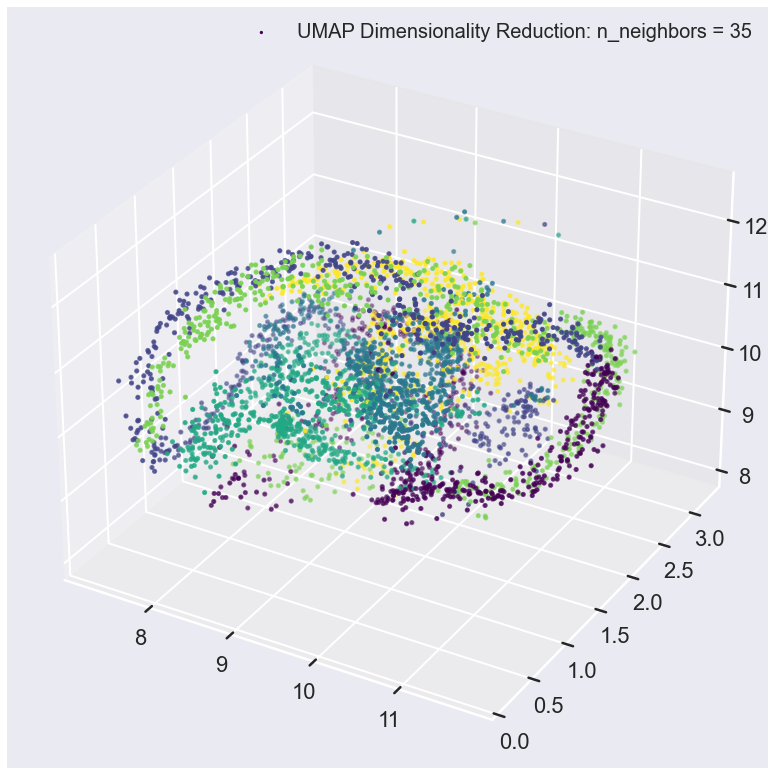

,model_name,accuracy_score,precision_score,recall_score,f1_score
3,K Nearest Neighbor,0.898418,0.899422,0.898467,0.898332
0,Random Forest,0.88343,0.883623,0.883759,0.883285
1,Decsision Tree,0.85179,0.851976,0.851752,0.85184
2,AdaBoost,0.49209,0.517792,0.491804,0.491233


In [36]:
fit = umap.UMAP(n_neighbors = 35,
                min_dist = .1,
                n_components = 3,
                metric = 'euclidean')

data_umap = fit.fit_transform(X_res_b)

sns.set(style='darkgrid', context='poster', rc={'figure.figsize':(20,14)})
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_umap[:,0], data_umap[:,1], data_umap[:,2], c=y_res_b, s=10, cmap='viridis')
leg = plt.legend(['UMAP Dimensionality Reduction: n_neighbors = 35'], loc='best', borderpad=0.3, 
                  shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'), markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.set_draggable(state=True)
plt.show()
        
model_dict = {'Random Forest': RandomForestClassifier(random_state=42),
              'Decsision Tree': DecisionTreeClassifier(random_state=42),
              'AdaBoost': AdaBoostClassifier(random_state=42),
              'K Nearest Neighbor': KNeighborsClassifier()}

#Train test split with stratified sampling for evaluation
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(data_umap, 
                                                    y_res_b, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    random_state = 3)

#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train_b, y_train_b)
        y_pred = v.predict(X_test_b)
        ac_score_list.append(accuracy_score(y_test_b, y_pred))
        p_score_list.append(precision_score(y_test_b, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test_b, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test_b, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)



In [ ]:
#KNN
n_neighbors = [5,7,10,15]
weights = ['uniform','distance']
leaf_size = [5,10,30,50]
p = [1,2]
n_jobs = [-1]

clf = KNeighborsClassifier()

params = dict(n_neighbors = n_neighbors,
              weights = weights,
              leaf_size = leaf_size,
              p = p,
              n_jobs = n_jobs)

gridsearch = GridSearchCV(clf,
                          params, 
                          cv=5,
                          verbose=1, 
                          n_jobs=-1)

knn_best_model = gridsearch.fit(X_res_b, y_res_b)

In [37]:
knn_best_model = KNeighborsClassifier(leaf_size=5,
                                      n_jobs=-1,
                                      n_neighbors=5,
                                      p =2,
                                      weights='distance')

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


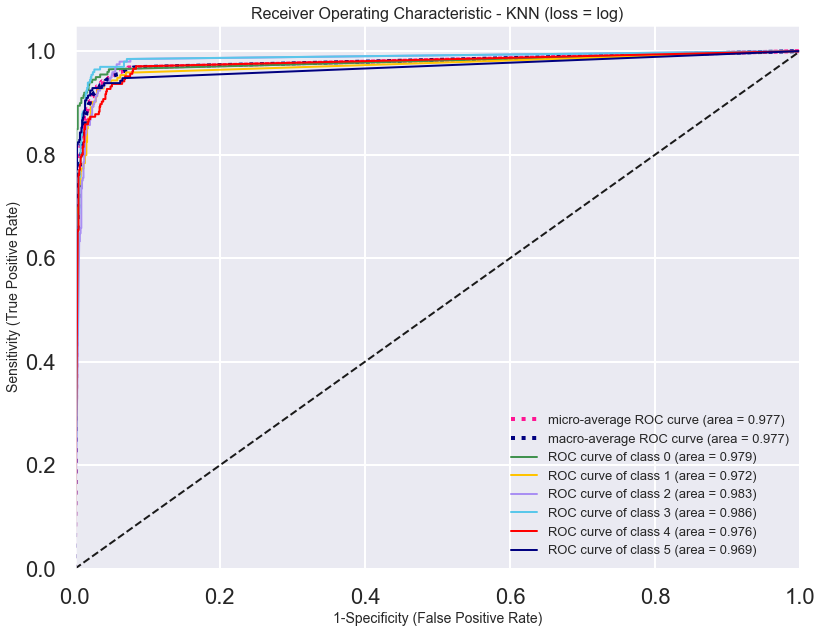

In [38]:
#Plot AUC - SGD
import numpy as np
#Binarize the labels
y_b = label_binarize(y_res_b, classes = [0, 1, 2, 3, 4, 5])
n_classes = y_b.shape[1]
#Shuffle and split training and test sets with stratified sampling and binarized labels
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(data_umap,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            random_state = 3)

#Learn to predict each class against the other
KNN_classifier = OneVsRestClassifier(knn_best_model)
y_score = KNN_classifier.fit(X_train_c, y_train_c).predict_proba(X_test_c)



#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_c[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_c.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

#First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

#Plot all ROC curves
plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')
lw=2

plt.plot(fpr['micro'], 
         tpr['micro'], 
         label='micro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['micro']),
         color='deeppink',
         linestyle=':', 
         linewidth=4)

plt.plot(fpr['macro'], 
         tpr['macro'], 
         label='macro-average ROC curve (area = {0:0.3f})'''.format(roc_auc['macro']),
         color='navy', 
         linestyle=':', 
         linewidth=4)

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA', 'red', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=lw, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 14)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 14)
plt.title('Receiver Operating Characteristic - KNN (loss = log)', fontsize = 16)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

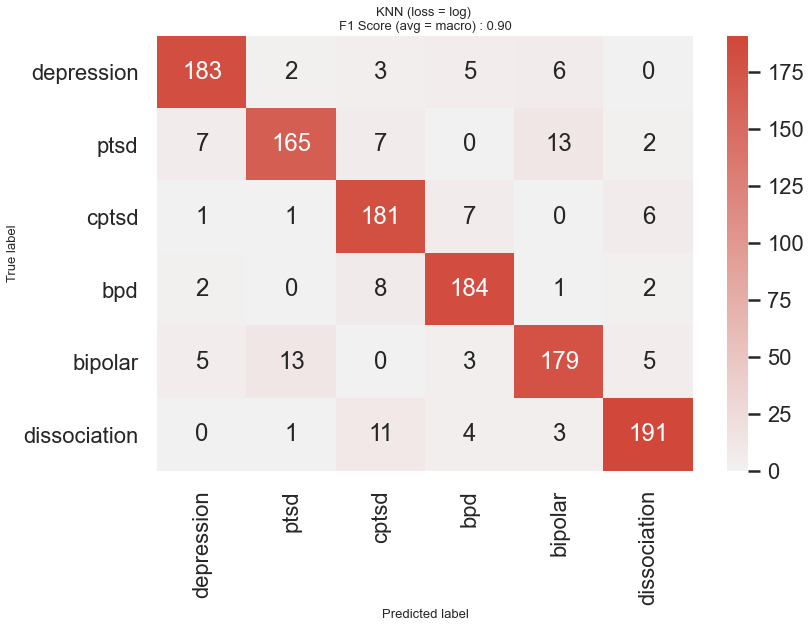

In [39]:
#Train test split with stratified sampling. Using non-binarized labels
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(data_umap, 
                                                            y_res_b, 
                                                            test_size = .3, 
                                                            shuffle = True, 
                                                            random_state = 3)
#Fit the training data
knn_best_model.fit(X_train_d, y_train_d)
y_pred = knn_best_model.predict(X_test_d)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test_d, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['depression','ptsd','cptsd', 'bpd', 'bipolar', 'dissociation'], 
                     columns = ['depression','ptsd','cptsd', 'bpd', 'bipolar', 'dissociation'])

#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('KNN (loss = log) \nF1 Score (avg = macro) : {0:.2f}'.format(f1_score(y_test_d, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()


In [42]:
unseen = df_holdout['text']
unseen = unseen.apply(clean_text)
unseen = unseen.apply(lambda x: TOKENIZER.tokenize(x))
unseen = unseen.apply(lambda x: word_lemmatizer(x))
unseen.dropna()
for text in unseen:
    if text == []:
        text.append('0')
unseen = unseen.astype('str')


X_unseen_tfidf = vectorizer.fit_transform(unseen).toarray() 
X_unseen = fit.fit_transform(X_unseen_tfidf)

knn_best_model.fit(data_umap,y_res_b)

#Make the prediction on the unseen articles with the fitted best models and put it into a df alongside the correct labels
df_holdout['pred_knn'] = knn_best_model.predict(X_unseen)


label_num_dict = {0: 0,
                  1: 1,
                  2: 2,
                  3: 3,
                  4: 4,
                  5: 5}
labels = ['0','1','2','3','4','5']

df_holdout['correct'] = df_holdout['label'].map(label_num_dict)
df_holdout = df_holdout[['text', 'label', 'pred_knn', 'correct']]

print(accuracy_score(df_holdout['correct'], df_holdout['pred_knn']))
print(classification_report(df_holdout['correct'], df_holdout['pred_knn'], target_names = labels))
df_holdout

0.16666666666666666
              precision    recall  f1-score   support

           0       0.17      1.00      0.29       100
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100
           5       0.00      0.00      0.00       100

    accuracy                           0.17       600
   macro avg       0.03      0.17      0.05       600
weighted avg       0.03      0.17      0.05       600



C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,text,label,pred_knn,correct
0,Does anyone else have intrusive thoughts and t...,0,0,0
1,My agony has started when I came off antidepre...,0,0,0
2,Two weeks I've been taking Sertraline. Mood is...,0,0,0
3,"Hi,\nI honestly don't know what is wrong with ...",0,0,0
4,"Hi, am I the only one who doesn't like my own ...",0,0,0
...,...,...,...,...
8805,I hate this feeling. \nI feel so disconnected\...,5,0,5
8806,so i mainly struggle with dissociation dpdr al...,5,0,5
8807,"I'm dissociatibg a lot, I suddenly change from...",5,0,5
8808,"Hey, everyone. I have been suffering with Depe...",5,0,5
